# Question A1 (15 marks)

#### Design a feedforward deep neural network (DNN) which consists of **three** hidden layers of 128 neurons each with ReLU activation function, and an output layer with sigmoid activation function. Apply dropout of probability **0.2** to each of the hidden layers.

* note: some cells are non-editable and cannot be filled, but leave them untouched. Fill up only cells which are provided.

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/SC4001/Assignment')

Mounted at /content/drive


In [2]:
!ls

drive  sample_data


In [4]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed # edit later

# setting seed
set_seed()

1. Define the model class.

In [31]:
class MLP(nn.Module):

    def __init__(self, no_features, no_hidden, no_labels):
        super().__init__()
        self.mlp_stack = nn.Sequential(
            # YOUR CODE HERE
            nn.Linear(no_features, no_hidden),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(no_hidden, no_hidden),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(no_hidden, no_hidden),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(no_hidden, no_labels),
            nn.Sigmoid()
        )

    # YOUR CODE HERE
    def forward(self, x):
      x = x.to(torch.float32)
      x = self.mlp_stack(x)
      return x
      # return torch.argmax(x)

#### Divide the dataset into a 70:30 ratio for training and testing. Use **appropriate** scaling of input features. We solely assume that there are only two datasets here: training & test.

1. Split the dataset and do preprocessing.

In [63]:
from common_utils import split_dataset, preprocess_dataset


def preprocess(df):
    # YOUR CODE HERE

    X_train, y_train, X_test, y_test = split_dataset(df=df,
                                                     columns_to_drop = ['filename', 'label'],
                                                     test_size=0.3,
                                                     random_state=19)
    X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)
    return X_train_scaled, y_train, X_test_scaled, y_test

# df = pd.read_csv('simplified.csv')

df = pd.read_csv('/content/drive/MyDrive/SC4001/Assignment/simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]

df['label'].value_counts()

X_train_scaled, y_train, X_test_scaled, y_test = preprocess(df)

#### Use the training dataset to train the model for 100 epochs. Use a mini-batch gradient descent with **‘Adam’** optimizer with learning rate of **0.001**, and **batch size = 256**. Implement early stopping with patience of **3**.

1. Define a Pytorch Dataset and Dataloaders.  

In [64]:
class CustomDataset(Dataset):
    # YOUR CODE HERE
    def __init__(self, x, y):
      self.x = torch.tensor(x, dtype=torch.float32)
      self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
      return len(self.x)
    def __getitem__(self, id):
      return self.x[id], self.y[id]
def intialise_loaders(X_train_scaled, y_train, X_test_scaled, y_test):
    # YOUR CODE HERE
    train = CustomDataset(X_train_scaled, y_train)
    test = CustomDataset(X_test_scaled, y_test)

    train_dataloader = DataLoader(train, batch_size=128)
    test_dataloader = DataLoader(test, batch_size=128)
    return train_dataloader, test_dataloader

train_dataloader, test_dataloader = intialise_loaders(X_train_scaled, y_train, X_test_scaled, y_test)

2. Next, define the model, optimizer and loss function.

In [65]:
X_train_scaled.shape[1]

77

In [66]:
# YOUR CODE HERE
model = MLP(X_train_scaled.shape[1], 128, 1)
optimizer = torch.optim.Adam(params=model.parameters())
loss_fn = nn.BCELoss()

3. Train model for 100 epochs. Record down train and test accuracies. Implement early stopping.

In [67]:
# YOUR CODE HERE
from common_utils import EarlyStopper
from tqdm import tqdm

epochs = 100
stopper = EarlyStopper()

In [74]:
training_loss_ = []
training_accuracy_ = []

test_loss_ = []
test_accuracy_ = []

for epoch in tqdm(range(epochs), desc='PROGRESS'):

  model.train()
  epoch_loss = []
  epoch_accuracy = []

  for inputs, labels in train_dataloader:

    #forward pass
    outputs = model.forward(inputs).squeeze().to(torch.float32)

    optimizer.zero_grad()

    # preds = torch.argmax(outputs, axis=1)
    # compute loss
    loss = loss_fn(outputs, labels)
    loss.backward()

    epoch_loss.append(loss)

    # update weight

    optimizer.step()

    accuracy = precision_score((outputs > 0.5).float(), labels)
    epoch_accuracy.append(accuracy)

  training_loss_.append(torch.mean(torch.stack(epoch_loss)).item())
  training_accuracy_.append(np.mean(epoch_accuracy))


  model.eval()
  epoch_loss = []
  epoch_accuracy = []
  with torch.no_grad():
    for inputs, labels in test_dataloader:

      outputs = model(inputs).squeeze().to(torch.float32)

      loss = loss_fn(outputs, labels)
      epoch_loss.append(loss)

      accuracy = precision_score((outputs > 0.5).float(), labels)
      epoch_accuracy.append(accuracy)

  test_loss_.append(torch.mean(torch.stack(epoch_loss)).item())
  test_accuracy_.append(np.mean(epoch_accuracy))

  if stopper.early_stop(test_loss_[-1]):
    print('EARLY STOPPING')
    break


PROGRESS:  22%|██▏       | 22/100 [00:14<00:49,  1.57it/s]

EARLY STOPPING


#### Plot train and test accuracies and losses on training and test data against training epochs and comment on the line plots.


In [53]:
import matplotlib.pyplot as plt

In [75]:
num_epoch = np.arange(1, len(training_loss_)+1)

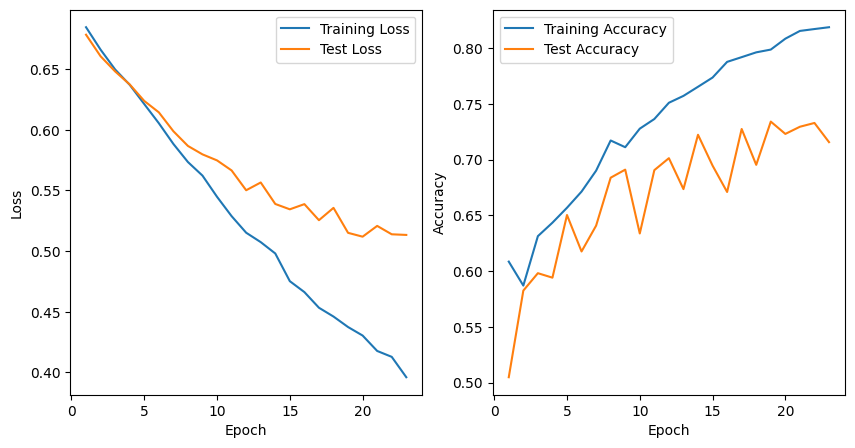

In [76]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(num_epoch, training_loss_, label='Training Loss')
plt.plot(num_epoch, test_loss_, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Second subfigure plot training and test accuracy against epochs
plt.subplot(1, 2, 2)
plt.plot(num_epoch, training_accuracy_, label='Training Accuracy')
plt.plot(num_epoch, test_accuracy_, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

2. Comment on line plots.

In [ ]:
# YOUR CODE HERE
answer = "Early Stopping Occurred when the model has not converged on the training data yet."
#We should increase the patience parameter on early stopping to see if the model is going to converge further
# Furthermore, the loss/accuracy on the test dataset is fluctuating really wildly.